# On Analyzing Real World Time Series for Forecasting Stock Data - Tencent

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '..'))

from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, AR, PersistenceWalkForward, MA, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Initialize Moving Average `MA(p, q)` Model
16. Predict Forecasts for Returns Data
17. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
18. Initialize Autoregressive Moving Average `ARMA(p, q)` Model
19. Predict Forecasts for Returns Data
20. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
21. Initialize `Persistence Random Walk` Model
22. Predict Forecasts for Returns Data
23. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2017-01-01", "2019-01-01"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("TCEHY", "Tencent"),
    ("INTC", "Intel")
]
independent_variable = "Close"
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'TCEHY'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([24.35000038, 24.47999954, 25.07999992, 25.32999992, 25.29999924,
       25.35000038, 26.01000023, 25.78000069, 25.64999962, 25.64999962,
       25.85000038, 25.75      , 25.5       , 25.47999954, 25.77000046,
       25.87999916, 26.43000031, 26.36000061, 26.25      , 26.18000031,
       26.79999924, 26.5       , 26.54999924, 26.56999969, 26.64999962,
       26.25      , 26.42000008, 26.18000031, 26.29999924, 26.23999977,
       26.54999924, 27.14999962, 27.21999931, 27.12000084, 27.67000008,
       27.68000031, 27.13999939, 27.04999924, 26.70000076, 26.93000031,
       26.64999962, 26.78000069, 26.82999992, 27.04999924, 27.39999962,
       26.93000031, 27.28000069, 27.72999954, 27.71999931, 27.53000069,
       28.5       , 28.60000038, 29.35000038, 29.54000092, 28.67000008,
       28.75      , 28.98999977, 28.93000031, 29.10000038, 29.52000046,
       29.15999985, 29.        , 29.03000069, 29.        , 29.55999947,
       29.35000038, 29.37000084, 29.30999947, 29.11000061, 29.61

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

,Close
Date,
2017-01-03,24.350000
2017-01-04,24.480000
2017-01-05,25.080000
2017-01-06,25.330000
2017-01-09,25.299999
...,...
2018-12-24,38.869999
2018-12-26,39.200001
2018-12-27,38.790001


### Plot Raw Data

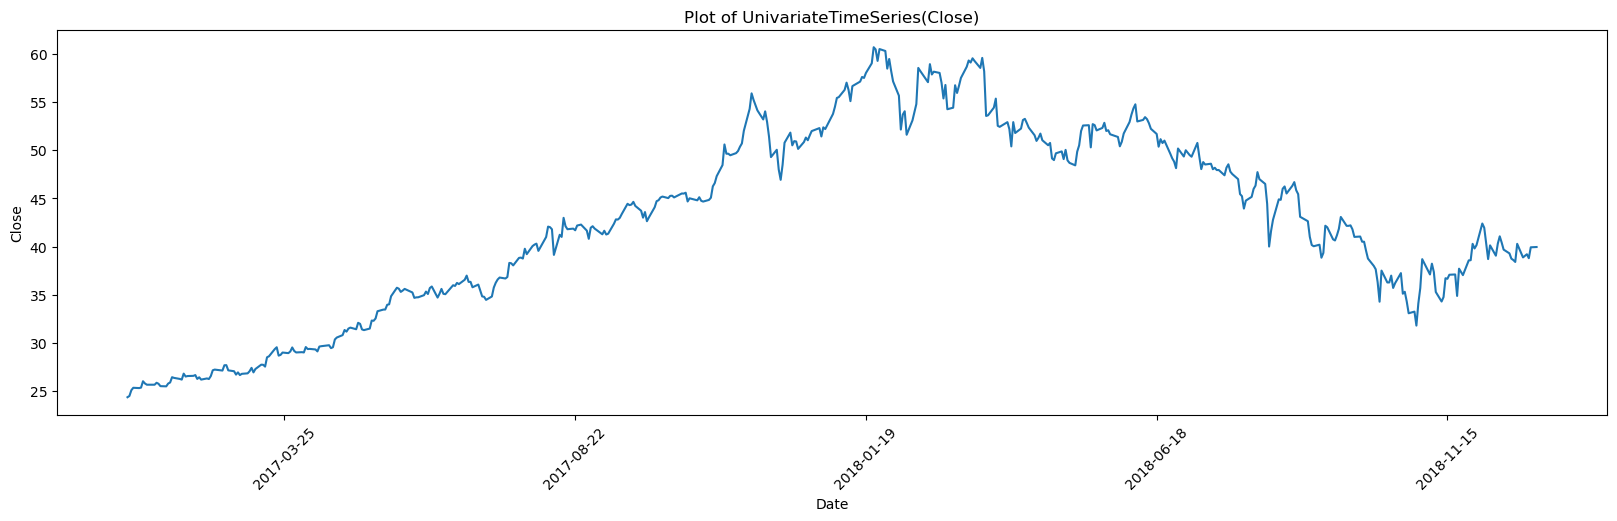

In [7]:
stocks[stock_symbol].plot(tick_skip=150)

In [8]:
(stock_series > 32).any()

True

<AxesSubplot: xlabel='Date'>

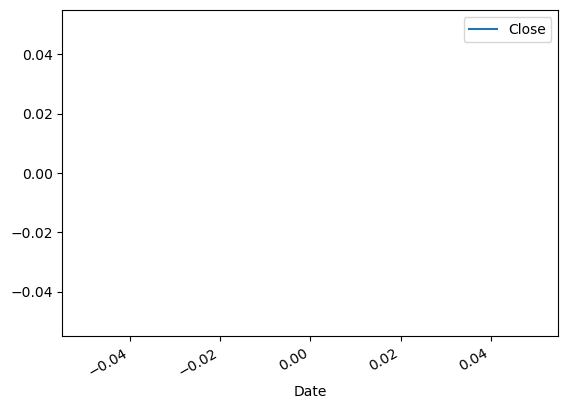

In [9]:
stock_df.loc['2020-01-01':'2022-01-01'].plot()

### Get Descriptive Statistics of Raw Data

In [10]:
stocks[stock_symbol].get_statistics()

,Close
count,502.000000
mean,42.535637
std,9.539756
min,24.350000
25%,35.599998
50%,42.215000
75%,50.757499
max,60.700001


In [11]:
stocks[stock_symbol].max_min_range()

{'Max': Close    60.700001
 dtype: float64,
 'Min': Close    24.35
 dtype: float64,
 'Range': Close    36.35
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [12]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: -1.929091
p-value: 0.318502 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

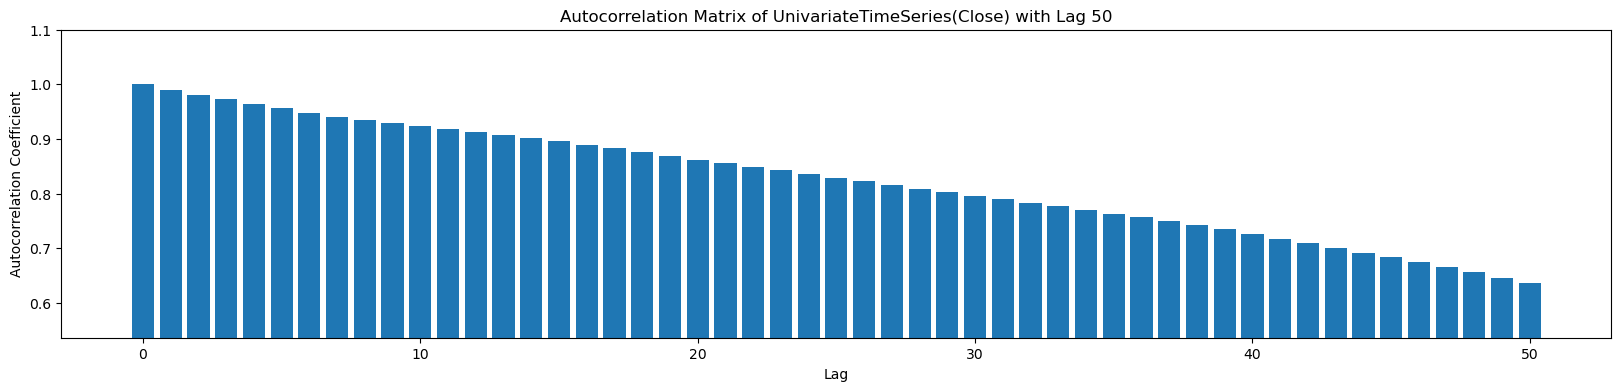

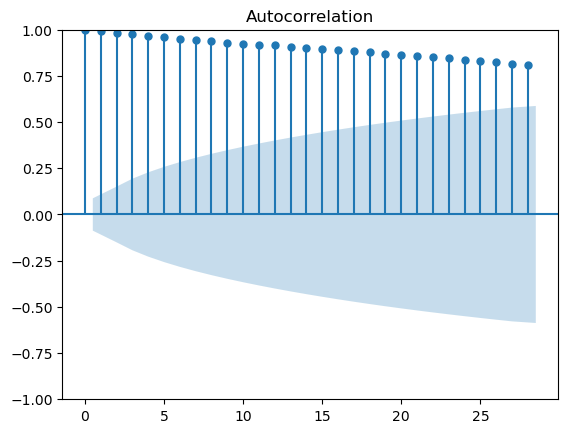

In [13]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

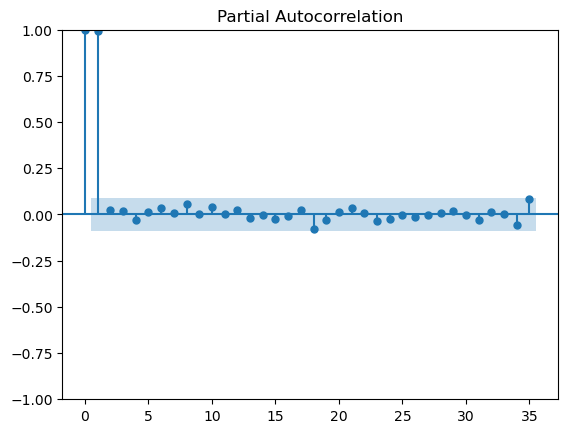

In [14]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

### Get Returns Data

- Forecast returns
- Why: To have more stationarity (for the returns) compared to the prices `Open`/`Close` which is non-stationary
- Calculate with the `change` between $ z_t $ and $ z_{t-1} $
$$ Change = ((z_t - z_{t-1}) \div | z_{t-1} |) \space \rightarrow decimal \space form $$
$$ Percent \space Change = Change \times 100 \space \rightarrow pecent \space form $$
    - If `change` < 0, then stock price is going down, hence a **loss** from $ z_{t-1} \rightarrow z_t $
    - If `change` > 0, then stock price is going up, hence a **gain** from $ z_{t-1} \rightarrow z_t $
    - If `change` = 0, then stock price is constant, hence a **no loss nor no gain** from $ z_{t-1} \rightarrow z_t $
- NOTE: Shift the date by 1 because we don't have anything to subtract the 0th date by.

In [15]:
stock_returns = stocks[stock_symbol].data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

In [16]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2017-01-04,0.005339
2017-01-05,0.024510
2017-01-06,0.009968
2017-01-09,-0.001184
2017-01-10,0.001976
...,...
2018-12-24,-0.035005
2018-12-26,0.008490
2018-12-27,-0.010459


### Plot Returns Data

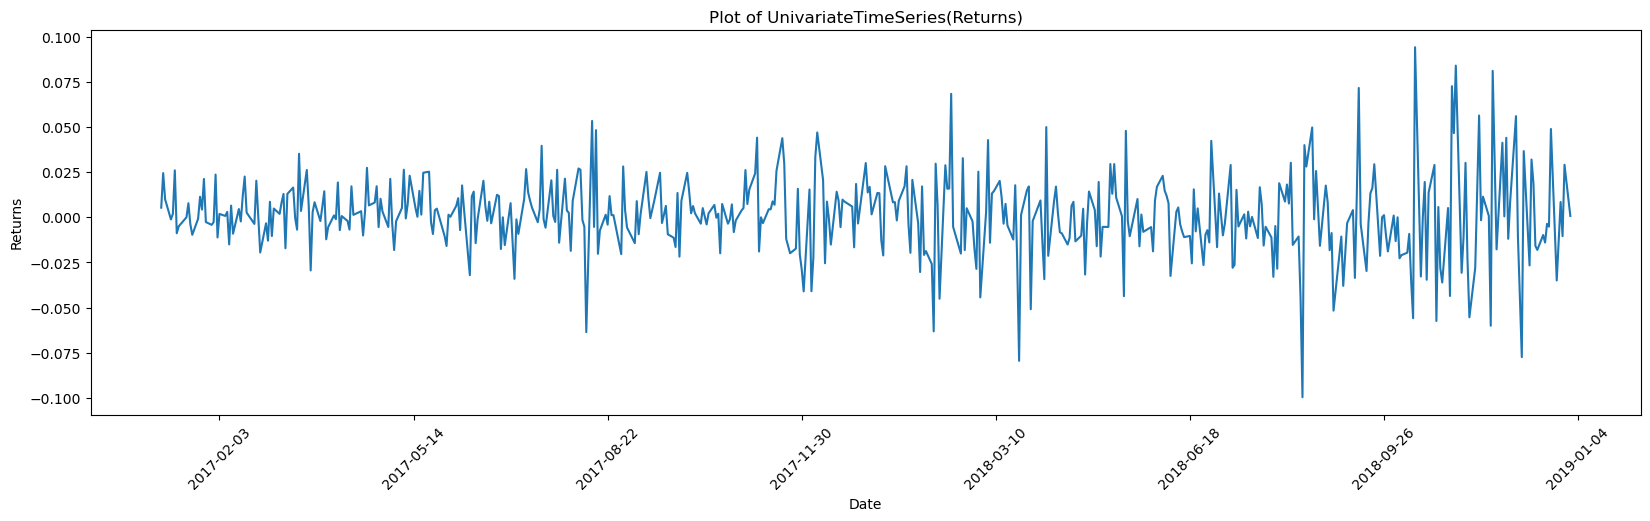

In [17]:
stock_returns.plot(tick_skip=100)

- Returns seem to have constant mean and constant variance although there are larger increases in 2015, 2019/2020, and Q1 & Q2 of 2022.

### Get Descriptive Statistics of Returns Data

In [18]:
stock_returns.get_statistics()

,Returns
count,501.000000
mean,0.001236
std,0.022275
min,-0.099707
25%,-0.010393
50%,0.001307
75%,0.012997
max,0.094252


### Check Stationarity of Returns Data

In [19]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -23.873208
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

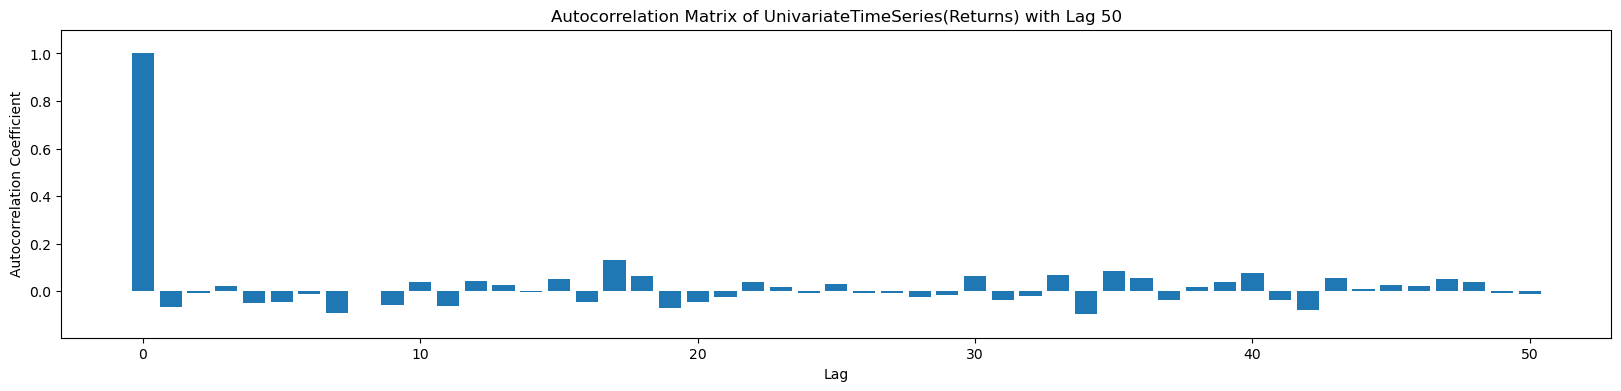

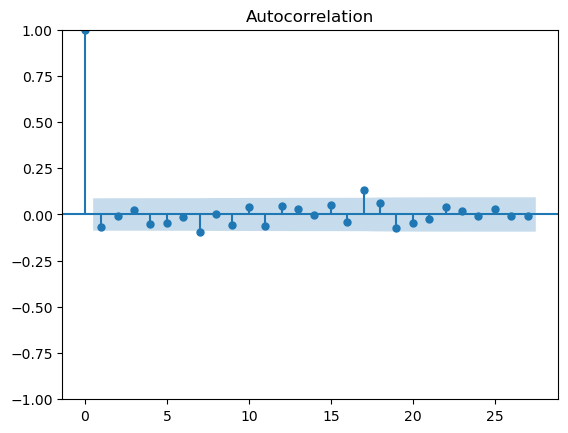

In [20]:
stock_returns.plot_autocorrelation(50)

- The ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with MA(1).

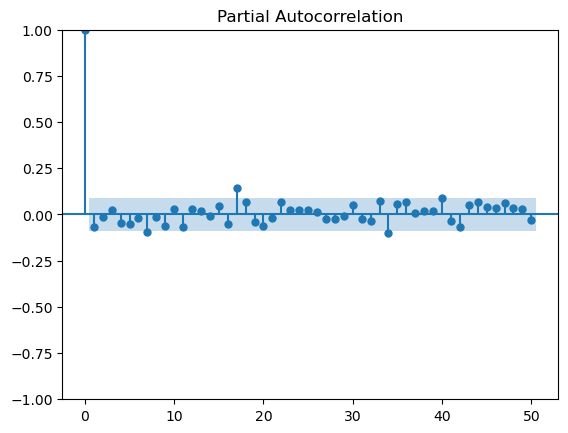

In [21]:
stock_returns.plot_partial_autocorrelation(50)

- The Partial ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with AR(1).

### Split Returns Data

- Splitting so we can forecast the last 7 days. Do this type of forecast to see how model is performing. If model performs how we need, then update notebook to forecast the next 7 days.

In [22]:
stock_returns_len = len(stock_returns_df)
stock_returns_len

501

In [23]:
get_train_len = len(stock_returns_df[:3465])
get_train_len

501

In [24]:
get_train_percentage = float(get_train_len / stock_returns_len)
get_train_percentage

1.0

In [25]:
train, validation, test = stock_returns.get_train_validation_test_split(get_train_percentage, 0.0)

0 501
501 501
501 501


In [26]:
train

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[0:501])

In [27]:
train.get_as_df()

,UnivariateTimeSeries(Returns)[0:501]
Date,
2017-01-04,0.005339
2017-01-05,0.024510
2017-01-06,0.009968
2017-01-09,-0.001184
2017-01-10,0.001976
...,...
2018-12-24,-0.035005
2018-12-26,0.008490
2018-12-27,-0.010459


In [28]:
test

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[501:501])

In [29]:
test.get_as_df()

,UnivariateTimeSeries(Returns)[501:501]
Date,


In [30]:
expected_forecast = test.get_series()
expected_forecast

array([], dtype=float64)

### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot.

In [31]:
positive_pacor = [1]
negative_pacor = []
lags_to_test = positive_pacor + negative_pacor
lags_to_test = sorted(lags_to_test)
lags_to_test

[1]

In [32]:
# create an object from the AR() class
ar_model_class = AR()

# call the function to train our AR model
trained_ar_models = ar_model_class.train_ar_model(train.get_series(), lags_to_test)

Model 1 with a lag of 1
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  501
Model:                     AutoReg(1)   Log Likelihood                1193.823
Method:               Conditional MLE   S.D. of innovations              0.022
Date:                Sat, 09 Dec 2023   AIC                          -2381.646
Time:                        19:30:12   BIC                          -2369.002
Sample:                             1   HQIC                         -2376.685
                                  501                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.317      0.188      -0.001       0.003
y.L1          -0.0673      0.045     -1.509      0.131      -0.155       0.020
                            

In [33]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

501

### Predict Forecasts of Retruns Data

In [34]:
predictions = ar_model_class.predict(trained_ar_models, len_historical_data, train, test)
predictions

TypeError: predict() takes 4 positional arguments but 5 were given

In [ ]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, predictions)
mse_gsts

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

In [ ]:
EvaluationMetric.plot_forecast(expected_forecast, predictions, lags_to_test)

### Initialize Moving Average MA(q) Model

In [ ]:
test_error_terms = [1, 13, 18, 35]

In [ ]:
# create an object from the MA() class
ma_model_class = MA()

# call the function to train our AR model
trained_ma_models = ma_model_class.train_model(train.get_series(), test_error_terms)

In [ ]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

### Predict Forecasts of Returns Data

In [ ]:
ma_predictions = ma_model_class.predict(trained_ma_models, len_historical_data, train, test)
ma_predictions

In [ ]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, ma_predictions)
mse_gsts

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

In [ ]:
EvaluationMetric.plot_forecast(expected_forecast, ma_predictions, test_error_terms)

### Initialize Moving Average ARMA(p, q) Model

In [ ]:
lags_to_test

In [ ]:
test_error_terms = [1]
test_error_terms

In [ ]:
# create an object from the ARMA() class
arma_model_class = ARMA()

# call the function to train our AR model
trained_arma_models = arma_model_class.train_arma_model(train.get_series(), lags_to_test, test_error_terms)

In [ ]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

### Predict Forecasts of Returns Data

In [ ]:
arma_predictions = arma_model_class.predict(trained_arma_models, len_historical_data, train, test)
arma_predictions

In [ ]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, arma_predictions)
mse_gsts

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

In [ ]:
EvaluationMetric.plot_forecast(expected_forecast, arma_predictions, lags_to_test)

### Initialize Persistence Random Walk Model

In [ ]:
# create an object from the PersistenceWalkForward() class
random_walk_model = PersistenceWalkForward()

In [ ]:
stock_returns_df

In [ ]:
stock_returns.get_series()

In [ ]:
stock_returns_lags_df = random_walk_model.augment_data(stock_returns_df, 1)
stock_returns_lags_df

In [ ]:
X = stock_returns_lags_df.values
X

In [ ]:
# start at 1 to drop nan
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
import numpy as np

### Predict Forecasts of Returns Data

In [ ]:
prw_predictions = random_walk_model.predict(test_X)
prw_predictions = np.array(prw_predictions)
prw_predictions

In [ ]:
mse_stock_returns = EvaluationMetric.eval_mse(test_y, prw_predictions, per_element=False)
mse_stock_returns

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

In [ ]:
lags_to_test = [0]
EvaluationMetric.plot_forecast(test_y, prw_predictions, lags_to_test, with_lags=False)

### Follow-up
- What can we determine from this?
    - None of the models with the specified lag are performing well. Why?
- Which AR(p) lag performs the best?
    - Difficult to state. 
- Can we do better?
    - We must lol!